# Case 1

- Open the TFP.csv file attached.

- The series is composed by TFP (rtfpna variable) at constant national prices (2005 = 1) for three countries: United States (USA), Canada (CAN) and Mexico (MEX).

1.1 Make an exploratory data analysis;

1.2 Forecast 10 years of the series (if you are performing the exercise in R, use package “forecast”);

1.3 Check in the following link pages 2 and 3: https://cran.r-project.org/web/packages/pwt8/pwt8.pdf to see a list of all variables in the original dataset. Can you think about another feature that could be helpful in explaining TFP series? Explain.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as sc
import seaborn as sns
import statsmodels.api as sm

In [2]:
%matplotlib inline
sns.set()
sns.set_style('white')

# figure style options
fig_style = {
    'figsize': (12,5)
}

In [3]:
df = pd.read_csv('assets/TFP.csv', parse_dates=['year'])

## Descriptive statistics

In [4]:
df.head()

,isocode,year,rtfpna
0,USA,1950-01-01,0.617148
1,USA,1951-01-01,0.629588
2,USA,1952-01-01,0.638451
3,USA,1953-01-01,0.651858
4,USA,1954-01-01,0.646179


First, we will pivot the data to analyze the time series individually:

In [5]:
df = df.pivot(columns='isocode', index='year', values='rtfpna')
df.head()

isocode,CAN,MEX,USA
year,,,
1950-01-01,0.843335,0.798159,0.617148
1951-01-01,0.855123,0.860931,0.629588
1952-01-01,0.896489,0.876968,0.638451
1953-01-01,0.910658,0.855204,0.651858
1954-01-01,0.875178,0.929168,0.646179


Now, the descriptive statistics:

In [6]:
df.describe()

isocode,CAN,MEX,USA
count,62.000000,62.000000,62.000000
mean,0.992886,1.130132,0.803824
std,0.050126,0.158209,0.116121
min,0.843335,0.798159,0.617148
25%,0.973294,1.012231,0.739949
50%,1.004211,1.093859,0.766047
75%,1.029513,1.299591,0.880544
max,1.066104,1.383718,1.020392


Are the time series linearly correlated?

In [7]:
df.corr()

isocode,CAN,MEX,USA
isocode,,,
CAN,1.000000,0.642937,0.334445
MEX,0.642937,1.000000,-0.259193
USA,0.334445,-0.259193,1.000000


Here, we inspect the time series, in level and first order difference:

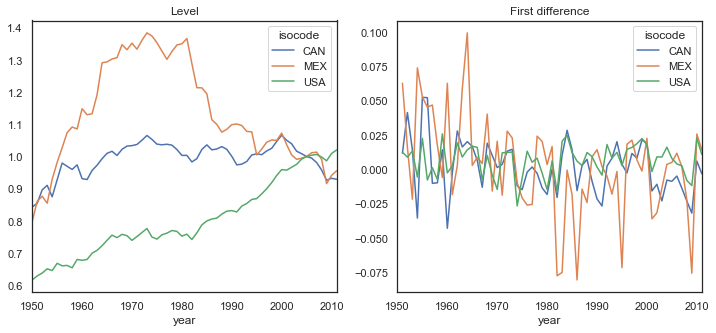

In [8]:
fig, ax = plt.subplots(1,2, **fig_style)

df.plot(ax=ax[0], title='Level')
df.diff().plot(ax=ax[1], title='First difference')

C:\Users\gsalt\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:444: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # will not work for two columns.
C:\Users\gsalt\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:444: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # will not work for two columns.


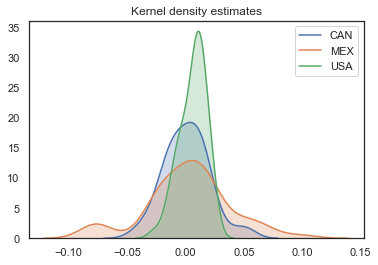

In [9]:
plt.title('Kernel density estimates')
[sns.kdeplot(df[series].diff(), shade=True) for series in df.columns]

In general, data shows greater uncertainty in Canada and Mexico total productivity growth.

## Time series analysis

Before diving into time series modelling, we should inspect the series key characteristics, such as stationariety and cointegration.

Upon earlier inspection, it is reasonable to assume the time series are non-stationary, as they exhibit well-defined trends. Nevertheless, we run statistical test for stationariety, namely the augmented Dickey and Fuller test, with constant and trend. The following are the MacKinnon (1994) p-values.

In [10]:
{series: sm.tsa.stattools.adfuller(df[series], regression='ct')[1] for series in df.columns}

{'CAN': 0.40231219825326797,
 'MEX': 0.40455390107688016,
 'USA': 0.8564670460105449}

Under a 95% confidence interval, we can reject the null hypothesis that each time series is stationary.

Next, we investigate cointegration relationships between time series. Cointegration analysis aims to find a long-term relationship between two time series. I then run the Engle and Granger (1991) cointegration test for all combinations of time series.

In [11]:
from itertools import combinations

In [12]:
combs = [*combinations(df.columns, 2)]
{s1+' and '+s2: sm.tsa.stattools.coint(df[s1], df[s2])[1] for s1, s2 in combs}

{'CAN and MEX': 0.34039072636371265,
 'CAN and USA': 0.34335400101285196,
 'MEX and USA': 0.27111508418576913}

Analyzing the p-values I'm unable to find cointegrating relationships between TFP series. Hence, I will discard forecasting using multivariate time series models, such as vector autoregressions.

## Forecasting

In [ ]:
# for each time series
for series in df.columns:
    
    # declare model
    model = sm.tsa.SARIMAX(df[series], order=(1,1,1), trend='c')
    steps = 10

    # fit model
    mod_fit = model.fit()
    forecast = mod_fit.get_forecast(steps).summary_frame()
    
    # plot forecast
    fig, ax = plt.subplots(**fig_style)
    plt.title('Forecast for '+series)
    plt.plot(df[series])
    plt.plot(forecast['mean'])
    ax.fill_between(forecast.index, forecast['mean_ci_lower'], forecast['mean_ci_upper'], color='k', alpha=0.1)

- Check in the following link pages 2 and 3: https://cran.r-project.org/web/packages/pwt8/pwt8.pdf to see a list of all variables in the original dataset. Can you think about another feature that could be helpful in explaining TFP series? Explain.

Surely, the macroeconomic literature on economic growth points to key aggregates correlated to total factor productivity present in Penn World Tables. If we define total factor productivity as the residual of the Solow model with labor: $Y_t = AK^{\alpha}L^{1-\alpha}$, productivity should emerge from a combination of capital and labor inputs into economic growth. In the 1990's, the works of [Robert Barro](https://www.nber.org/papers/w2588) and [David Romer](https://www.jstor.org/stable/2937632) point out the importance of human capital accumulation in economic growth, with empirical exercises on the U.S. economy. Some other works (notably from Chicago scholars) also attempt to correlate government size as a share of GDP and productivity, due to the [crowding-out](https://en.wikipedia.org/wiki/Crowding_out_(economics)) effect: government spending shrinks private investment - including research and development - which repels technological change.

# Case 2

Attached to this test is a .csv file which contains data from Comexstat, which is basically the official data source for brazilian exports e imports, maintened by the government;

The dataset contains all trackings of monthly imports and exports of a range of products (soybeans, soybean meal, soybean oil, corn, wheat and sugar), by brazilian states, by routes (air, sea, ground, etc) e from/to which country;

We ask you to address a couple quentions below. Remember that data viz is one important skill to show besides any analytical skill. So we encourage you to use and explore a bunch of graphs and tables to show your point.

Show the evolution of total monthly and total annual exports from Brazil (all states and to everywhere) of ‘soybeans’, ‘soybean oil’ and ‘soybean meal’;

What are the 3 most important products exported by Brazil in the last 5 years?

What are the main routes through which Brazil have been exporting ‘corn’ in the last few years? Are there differences in the relative importancem of routes depending on the product?

Which countries have been the most important trade partners for Brazil in terms of ‘corn’ and ‘sugar’ in the last 3 years?

For each of the products in the dataset, show the 5 most important states in terms of exports?

Now, we ask you to show your modelling skills. Feel free to use any type of modelling approach, but bear in mind that the modelling approach depends on the nature of your data, and so different models yield different estimates and forecasts. To help you out in this task we also provide you with a dataset of possible covariates (.xlsx). They all come from public sources (IMF, World Bank) and are presented in index number format. Question: What should be the total brazilian soybeans, soybean_meal, and corn export forecasts, in tons, for the next 11 years (2020-2030)? We’re mostly interested in the annual forecast.

In [3]:
comex = pd.read_csv('assets/data_comexstat.csv',
                    parse_dates=['date'], low_memory=False, encoding='iso-8859-1')

In [4]:
comex.head()

,date,product,state,country,type,route,tons,usd
0,1997-01-01,corn,ES,United States,Import,Sea,44.045,113029.0
1,1997-01-01,corn,GO,Argentina,Import,Ground,54.000,36720.0
2,1997-01-01,corn,GO,Bolivia,Export,Ground,0.200,180.0
3,1997-01-01,corn,GO,United States,Export,Sea,3.488,5688.0
4,1997-01-01,corn,MG,Argentina,Import,Ground,27.000,18630.0


In [5]:
comex['price per ton'] = comex['usd']/comex['tons']
comex['year'] = comex['date'].dt.year

- Show the evolution of total monthly and total annual exports from Brazil (all states and to everywhere) of ‘soybeans’, ‘soybean oil’ and ‘soybean meal’

In [158]:
tmpdf = comex.query("type=='Export' and (product == 'soybeans'\
            or product == 'soybean oil' or product == 'soybean meal')")\
    .groupby(['date'])\
    .sum()/1E6

Text(0, 0.5, 'Million tonnes')

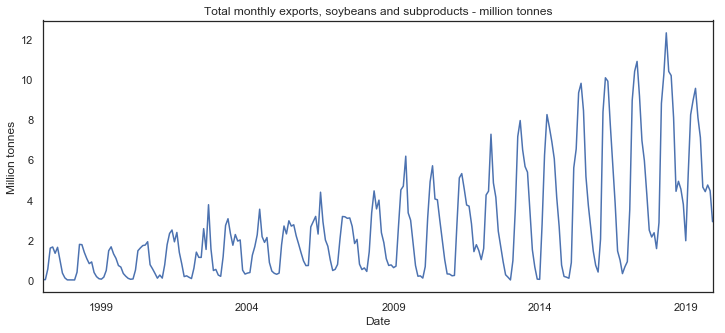

In [159]:
tmpdf['tons'].plot(title='Total monthly exports, soybeans and subproducts - million tonnes', **fig_style)
plt.xlabel('Date')
plt.ylabel('Million tonnes')

Text(0, 0.5, 'US$ millions')

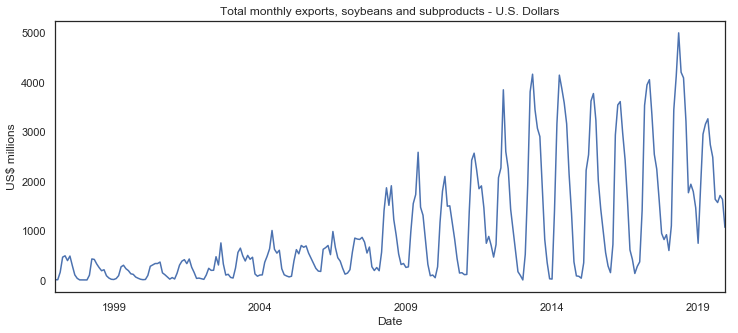

In [17]:
tmpdf['usd'].plot(title='Total monthly exports, soybeans and subproducts - U.S. Dollars', **fig_style)
plt.xlabel('Date')
plt.ylabel('US$ millions')

- What are the 3 most important products exported by Brazil in the last 5 years?

In [250]:
tmpdf = comex.query("type=='Export' and year >= 2015")\
    .groupby(['year','product'])\
    .sum()['usd']\
    .groupby(level=0, group_keys=False)\
    .nlargest(3)\
    .reset_index()\
    .pivot(index='year', columns='product', values='usd')/1E6

Text(0, 0.5, 'US$ millions')

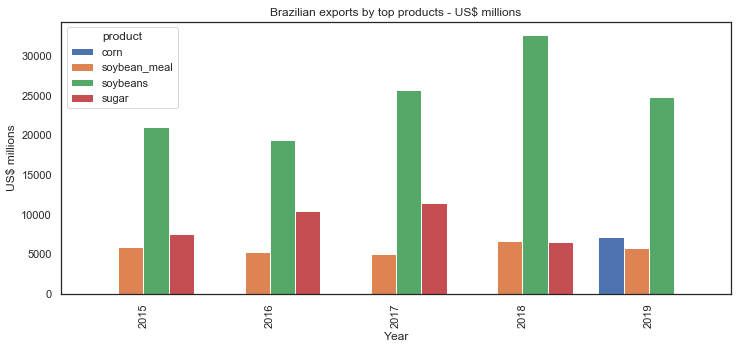

In [251]:
tmpdf.plot(kind='bar', title='Brazilian exports by top products - US$ millions', width=.8, **fig_style)
plt.xlabel('Year')
plt.ylabel('US$ millions')

- What are the main routes through which Brazil have been exporting ‘corn’ in the last few years? Are there differences in the relative importance of routes depending on the product?

In [252]:
tmpdf = comex.query("type=='Export' and product == 'corn' and year >= 2015")\
    .groupby(['date','route'])\
    .sum()/1E6

Text(0, 0.5, 'Million tonnes')

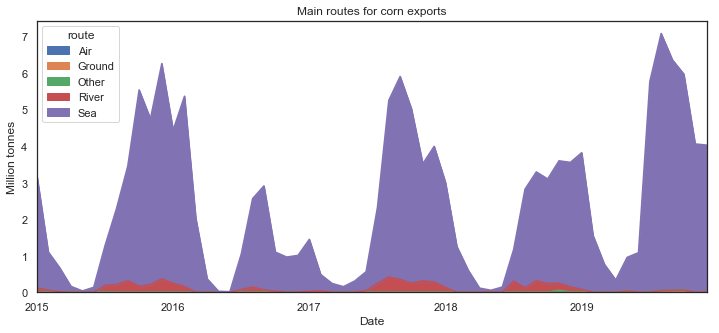

In [253]:
tmpdf.unstack()['tons'].plot(kind='area', title='Main routes for corn exports', **fig_style)
plt.xlabel('Date')
plt.ylabel('Million tonnes')

- Which countries have been the most important trade partners for Brazil in terms of ‘corn’ and ‘sugar’ in the last 3 years?

In [254]:
# corn exports
tmpdf = comex.query("product == 'corn' and date >= '2015-01-01' and type == 'Export'")\
    .groupby(['year','country'])\
    .sum()['usd']\
    .groupby(level=0, group_keys=False)\
    .nlargest(3)\
    .reset_index()\
    .pivot(index='year', columns='country', values='usd')/1E6

# corn imports
tmpdf2 = comex.query("product == 'corn' and date >= '2015-01-01' and type == 'Import'")\
    .groupby(['year','country'])\
    .sum()['usd']\
    .groupby(level=0, group_keys=False)\
    .nlargest(3)\
    .reset_index()\
    .pivot(index='year', columns='country', values='usd')/1E6

Text(0, 0.5, 'US$ millions')

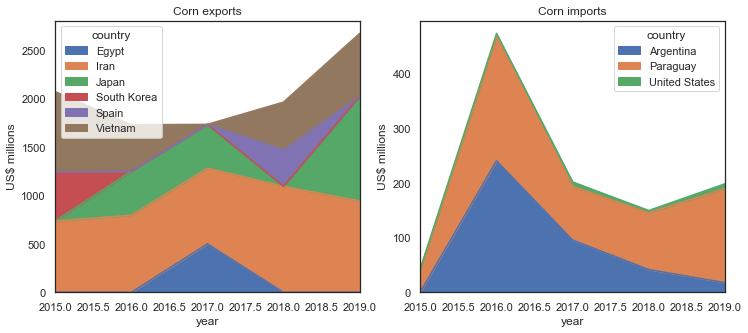

In [255]:
fig, ax = plt.subplots(1,2, **fig_style)
tmpdf.plot(kind='area', title='Corn exports', ax=ax[0])
ax[0].set_ylabel('US$ millions')

tmpdf2.plot(kind='area', title='Corn imports', ax=ax[1])
ax[1].set_ylabel('US$ millions')

- For each of the products in the dataset, show the 5 most important states in terms of exports?

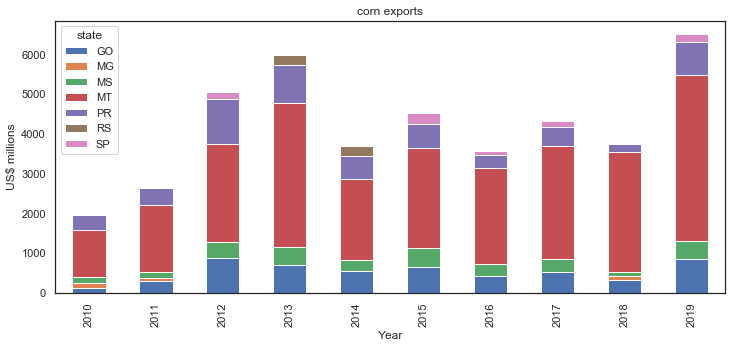

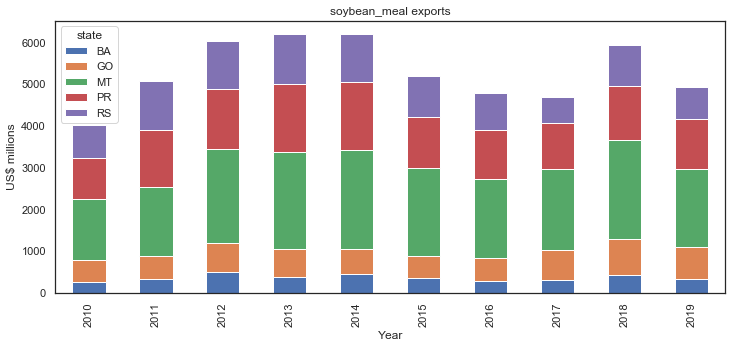

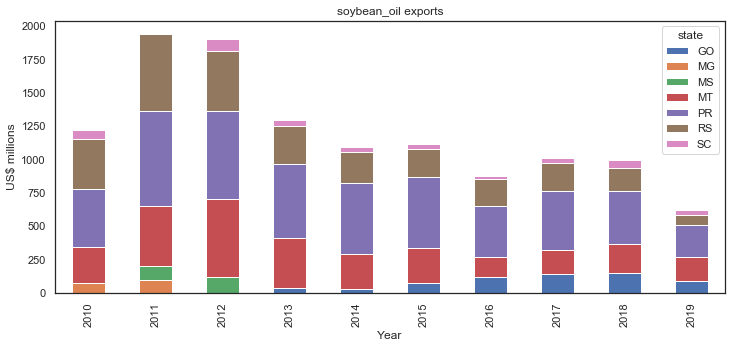

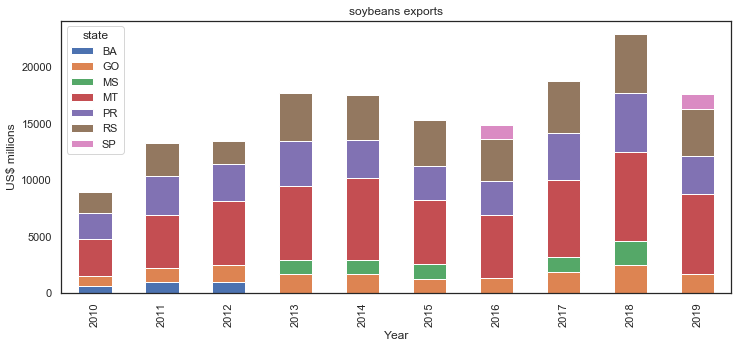

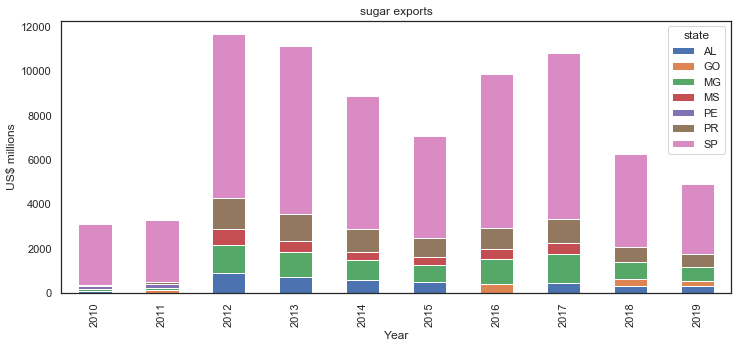

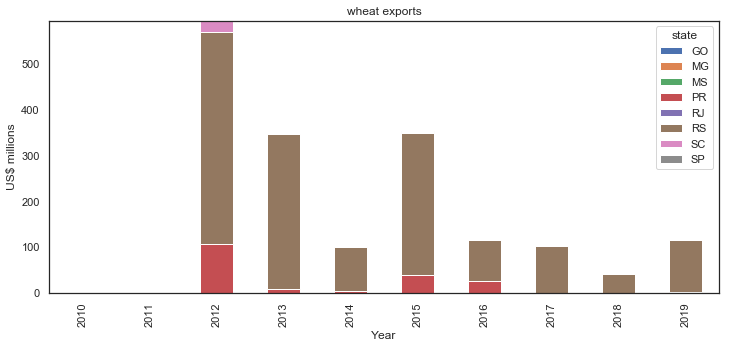

In [249]:
# loop through products
for product in comex['product'].unique().tolist():
    
    # find top 5 states by year for product
    tmpdf = comex.query(f"date > '2010-01-01' and type == 'Export' and product == '{product}'")\
        .groupby(['year','state'])\
        .sum()['usd']\
        .groupby(level=0, group_keys=False)\
        .nlargest(5)/1E6
    
    # pivot states into columns
    tmpdf = tmpdf.reset_index()\
        .pivot(index='year', columns='state', values='usd')
    
    # plot
    tmpdf.plot(kind='bar', stacked=True, **fig_style)
    plt.title(product+' exports')
    plt.ylabel('US$ millions')
    plt.xlabel('Year')

- Now, we ask you to show your modelling skills. Feel free to use any type of modelling approach, but bear in mind that the modelling approach depends on the nature of your data, and so different models yield different estimates and forecasts. To help you out in this task we also provide you with a dataset of possible covariates (.xlsx). They all come from public sources (IMF, World Bank) and are presented in index number format. Question: What should be the total brazilian soybeans, soybean_meal, and corn export forecasts, in tons, for the next 11 years (2020-2030)? We’re mostly interested in the annual forecast.

In [153]:
covariates = pd.read_excel('assets/covariates.xlsx', index_col='year', parse_dates=['year'])
covariates.head()

,price_soybeans,price_corn,price_soybean_meal,gdp_china,gdp_iran,gpd_netherlands,gdp_spain,gdp_thailand,gdp_world,gdp_egypt,gdp_japan,gdp_vietnam
year,,,,,,,,,,,,
1979-01-01,NaN,NaN,NaN,100.000000,100.000000,NaN,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
1980-01-01,100.000000,100.000000,100.000000,107.900000,81.200000,100.000000,101.200000,104.600000,102.100000,103.400000,103.200000,96.500000
1981-01-01,98.525508,103.888308,99.805440,113.402900,74.216800,99.500000,100.795200,110.771400,104.039900,105.674800,107.534400,102.097000
1982-01-01,83.406192,85.986430,86.596956,123.609161,83.939201,98.206500,102.004742,116.753056,104.664139,113.389060,111.083035,110.468954
1983-01-01,97.851743,108.168059,98.663318,136.958950,95.522811,99.974217,103.738823,123.291227,107.594735,123.480687,114.970941,118.312250


For this exercise, I will aggregate `comex` into an yearly dataset, aggregating states, countries and routes, for joining data with `covariates`.

In [156]:
# aggregate
comex['year'] = comex['date'].dt.year
comex_yearly = comex.groupby(['year','type','product']).agg({'usd': 'sum'}).reset_index()
comex_yearly = comex_yearly.pivot_table(index='year', columns=['product','type'], values=['usd'])

# flatten index
comex_yearly.columns = comex_yearly.columns.to_flat_index()
comex_yearly.reset_index(inplace=True)

# flatten column names
comex_yearly.columns = ['_'.join(t) for t in [*comex_yearly.columns]]
comex_yearly.columns = comex_yearly.columns.str.replace('usd_', '')
comex_yearly.rename({'y_e_a_r': 'year'}, axis=1, inplace=True)

# select columns for prediction
comex_yearly = comex_yearly[['year','soybeans_Export','soybean_meal_Export','corn_Export']]

# rescale into USD millions
comex_yearly.iloc[:, 1:] = comex_yearly.iloc[:, 1:]/1E6

# convert year into datetime
comex_yearly['year'] = pd.to_datetime(comex_yearly['year'], format='%Y')

# view data
comex_yearly.set_index('year', inplace=True)
comex_yearly.tail()

,soybeans_Export,soybean_meal_Export,corn_Export
year,,,
2015-01-01,20975.672739,5821.009079,5002.188893
2016-01-01,19328.432149,5192.780725,3736.202055
2017-01-01,25662.801909,4973.223446,4628.510219
2018-01-01,32619.856907,6624.036364,3956.254222
2019-01-01,24738.766153,5796.673823,7124.565521


Merging both datasets:

In [157]:
df = pd.merge(comex_yearly, covariates, how='left', left_index=True, right_index=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 23 entries, 1997-01-01 to 2019-01-01
Data columns (total 15 columns):
soybeans_Export        23 non-null float64
soybean_meal_Export    23 non-null float64
corn_Export            23 non-null float64
price_soybeans         23 non-null float64
price_corn             23 non-null float64
price_soybean_meal     23 non-null float64
gdp_china              23 non-null float64
gdp_iran               23 non-null float64
gpd_netherlands        23 non-null float64
gdp_spain              23 non-null float64
gdp_thailand           23 non-null float64
gdp_world              23 non-null float64
gdp_egypt              23 non-null float64
gdp_japan              23 non-null float64
gdp_vietnam            23 non-null float64
dtypes: float64(15)
memory usage: 3.5 KB


First, let's examine the correlation between covariates and our time series to be predicted:

In [158]:
df_corr = df.corr(method='pearson').round(3)
df_corr[['soybeans_Export','soybean_meal_Export','corn_Export']].style.background_gradient(cmap='coolwarm')

,soybeans_Export,soybean_meal_Export,corn_Export
soybeans_Export,1,0.92,0.893
soybean_meal_Export,0.92,1,0.881
corn_Export,0.893,0.881,1
price_soybeans,0.68,0.877,0.707
price_corn,0.606,0.807,0.677
price_soybean_meal,0.805,0.954,0.799
gdp_china,0.97,0.88,0.908
gdp_iran,0.827,0.818,0.723
gpd_netherlands,0.87,0.792,0.798
gdp_spain,0.737,0.686,0.654


As noted, the correlations are high - which is expected, as series grow along a constant upward trend. Let's examine the correlations with first differences:

In [159]:
df_diff_corr = df.diff().corr(method='pearson').round(3)
df_diff_corr[['soybeans_Export','soybean_meal_Export','corn_Export']].style.background_gradient(cmap='coolwarm')

,soybeans_Export,soybean_meal_Export,corn_Export
soybeans_Export,1,0.668,-0.283
soybean_meal_Export,0.668,1,-0.132
corn_Export,-0.283,-0.132,1
price_soybeans,0.337,0.638,0.158
price_corn,0.255,0.434,0.265
price_soybean_meal,0.464,0.829,0.06
gdp_china,0.154,0.118,0.221
gdp_iran,0.057,-0.182,-0.513
gpd_netherlands,-0.019,-0.205,-0.085
gdp_spain,-0.219,-0.381,-0.194


From the exercise above, we find interesting correlations, such as soybean prices and exports.

## Modelling task

For each time series (soybeans, soybean meal, corn exports), I first propose a SARIMAX model, which is an autoregressive time series model, with exogenous variables and possibly seasonal effects. The AR and MA orders will be selected upon examination of autocorrelation plots and with the aid of automatic selecting.

The model takes the form: $\Delta^d y_t = c+\nu t + \sum_1^p \phi_p \Delta^d y_{t-p} + \sum_1^q \theta_q \Delta^d e_{t-q} + e_t $

where $c$ is the intercept, $d$ is the differencing order, $p$ is the AR order, $q$ is the MA order and $\nu$ is the linear trend.

Let's define the time series:

In [160]:
soybeans_export = df['soybeans_Export']
soybean_meal_export = df['soybean_meal_Export']
corn_export = df['corn_Export']

Now, the autocorrelation plots:

C:\Users\gsalt\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1406: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


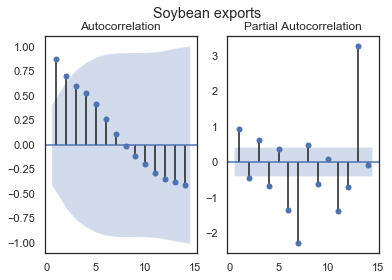

In [161]:
fig, ax = plt.subplots(1,2)

fig.suptitle('Soybean exports')
sm.graphics.tsa.plot_acf(soybeans_export, ax=ax[0], zero=False)
sm.graphics.tsa.plot_pacf(soybeans_export, ax=ax[1], zero=False)
plt.show()

For soybean exports, we find evidence of MA effects (due to the oscillating pattern in the PACF plot) and a seasonal spike at the 13th lag.

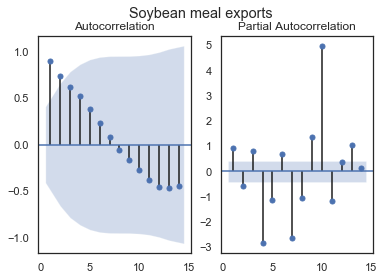

In [162]:
fig, ax = plt.subplots(1,2)

fig.suptitle('Soybean meal exports')
sm.graphics.tsa.plot_acf(soybean_meal_export, ax=ax[0], zero=False)
sm.graphics.tsa.plot_pacf(soybean_meal_export, ax=ax[1], zero=False)
plt.show()

In the case of soybean meal exports, a similar pattern emerges, with long-term seasonal effects at lag 10.

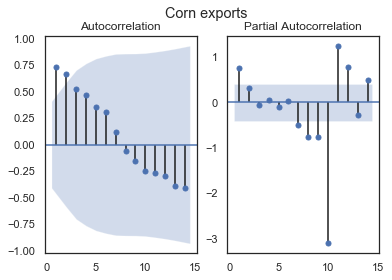

In [163]:
fig, ax = plt.subplots(1,2)

fig.suptitle('Corn exports')
sm.graphics.tsa.plot_acf(corn_export, ax=ax[0], zero=False)
sm.graphics.tsa.plot_pacf(corn_export, ax=ax[1], zero=False)
plt.show()

Finally, for corn exports there are well defined AR(1) effects and a seasonal spike at lag 10.

### SARIMAX model

In [29]:
import statsmodels.api as sm

#### Soybean exports

In [ ]:
# find order according to ARIMA(p,q)
arma_order = sm.tsa.stattools.arma_order_select_ic(soybeans_export.diff().dropna(), trend='c', ic=['bic'])['bic_min_order']

# declare model
ts_model = sm.tsa.SARIMAX(endog=soybeans_export, exog=covariates.loc[soybeans_export.index, :],
                          order=(arma_order[0],1,arma_order[1]),
                          seasonal_order=(1,0,0,6), trend='ct')
ts_fit = ts_model.fit()
ts_fit.summary()

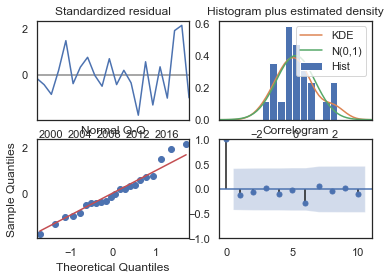

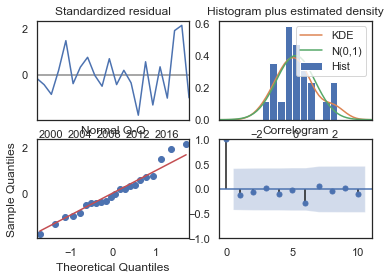

In [250]:
ts_fit.plot_diagnostics()

By default, `statsmodels` does not provide a method for forecast plots, so I will provide my own:

In [251]:
def plot_forecast(model_fit, y, steps, exog_predict, title):
    
    # get forecast data
    fc_data = model_fit.get_forecast(steps=steps, exog=exog_predict).summary_frame()
    
    plt.figure(**fig_style)
    plt.title(title)
    plt.plot(y) # actual
    plt.plot(ts_fit.predict()) # predicted
    plt.plot(fc_data['mean']) # forecast
    plt.fill_between(fc_data.index, fc_data['mean_ci_lower'], fc_data['mean_ci_upper'],
                    color='k', alpha=0.1) # confidence interval
    plt.legend([
        'Actual',
        'Predicted',
        'Forecast',
        '95% confidence interval'
    ])
    plt.ylabel('US$ millions')
    plt.xlabel('Year')

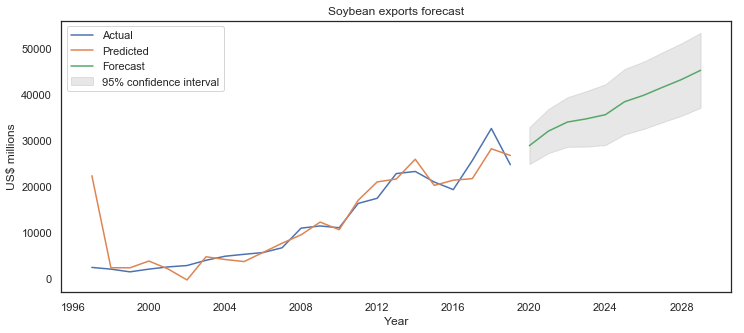

In [252]:
plot_forecast(ts_fit, soybeans_export, steps=10,
              exog_predict=covariates.loc[covariates.index>'2019-01-01',:][:10],
              title='Soybean exports forecast')

#### Soybean meal exports

In [ ]:
# find order according to ARIMA(p,q)
arma_order = sm.tsa.stattools.arma_order_select_ic(soybean_meal_export.diff().dropna(), trend='c', ic=['bic'])['bic_min_order']

# declare model
ts_model = sm.tsa.SARIMAX(endog=soybean_meal_export, exog=covariates.loc[soybean_meal_export.index, :],
                          order=(arma_order[0],1,arma_order[1]),
                          seasonal_order=(1,0,0,10), trend='ct')
ts_fit = ts_model.fit()
ts_fit.summary()

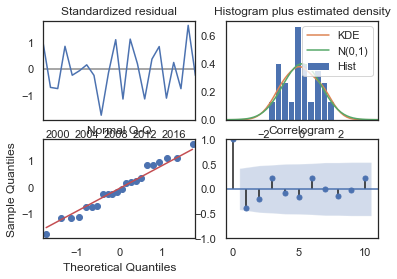

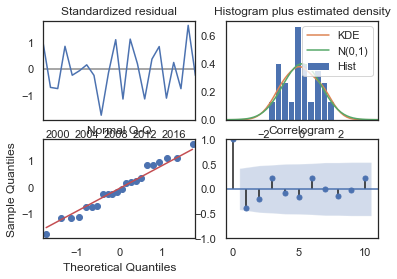

In [254]:
ts_fit.plot_diagnostics()

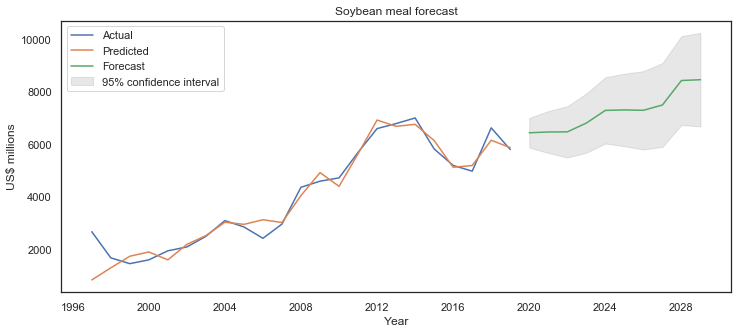

In [255]:
plot_forecast(ts_fit, soybean_meal_export, steps=10,
              exog_predict=covariates.loc[covariates.index>'2019-01-01',:][:10],
              title='Soybean meal forecast')

#### Corn exports

In [ ]:
# find order according to ARIMA(p,q)
arma_order = sm.tsa.stattools.arma_order_select_ic(corn_export.diff().dropna(), trend='c', ic=['bic'])['bic_min_order']

# declare model
ts_model = sm.tsa.SARIMAX(endog=corn_export, exog=covariates.loc[corn_export.index, :],
                          order=(1,1,arma_order[1]),
                          seasonal_order=(0,0,0,10), trend='ct')
ts_fit = ts_model.fit()
ts_fit.summary()

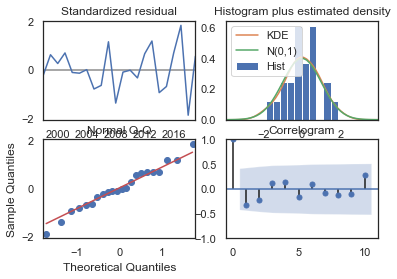

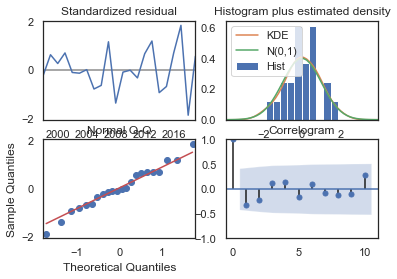

In [267]:
ts_fit.plot_diagnostics()

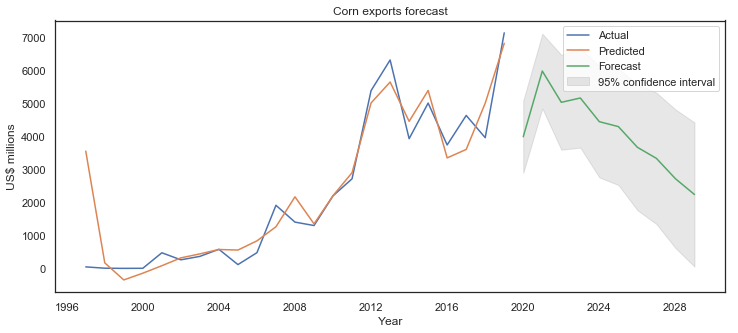

In [268]:
plot_forecast(ts_fit, corn_export, steps=10,
              exog_predict=covariates.loc[covariates.index>'2019-01-01',:][:10],
              title='Corn exports forecast')

# Expanding research

The analysis above was not, in any way, exhaustive. For instance, one could explore long-term relationships between the time series investigated above, such as co-integration. That could lead to multivariate models such as vector autoregressions. Also, there might be other interesting variables that influence commodities exports, such as:

- Exchange rates: the USD/BRL rate directly influence the appetite for Brazilian commodities exports.
- Relative prices between commodities: this ratio indirectly affects the decisions for farmers of which crop to plant, determining foreign supply/demand of commodities in the future (i.e. the dilemma for U.S. farmers of choosing between corn, soybeans or the prevented plant programme).
- Agricultural and climate data: expectations for planted area such as found in [U.S. World Supply and Demand data](https://www.usda.gov/oce/commodity/wasde/).